# Fake News detection with tensorflow and nltk using LSTMs

# Libraries setup

In [1]:
# Import all necessary libraries for preprocessing and model building
import re
from typing import Iterable

import matplotlib.pyplot as plt
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, roc_curve)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.metrics import classification_report

plt.style.use("ggplot")

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Discovery and preprocessing

## Download dataset from kaggle

In [ ]:
# Install kaggle library
!pip install -q kaggle

In [ ]:
# Import kaggle API token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kamilkisiel","key":"23b9b239ba34c26a0dd9a438adb5025b"}'}

In [ ]:
# Activate kaggle token
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset as zip
!kaggle datasets download mohammadaflahkhan/fake-news-dataset-combined-different-sources

 91% 73.0M/80.3M [00:01<00:00, 57.7MB/s]
100% 80.3M/80.3M [00:01<00:00, 66.7MB/s]


In [ ]:
!mkdir data
!unzip fake-news-dataset-combined-different-sources.zip -d data
!mv ./data/PreProcessedData.csv ./data/RawKaggleData.csv

Archive:  fake-news-dataset-combined-different-sources.zip
  inflating: data/PreProcessedData.csv  


## Data - first look

In [ ]:
# Load dataset
df = pd.read_csv("./data/RawKaggleData.csv")

In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [ ]:
len(df)

69045

In [ ]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


## Data split for model training / work validation

In [ ]:
df_train, df_validation = train_test_split(df, test_size=0.30, random_state=33)

In [ ]:
df_train.to_csv("fakenews-data-train.csv")
df_validation.to_csv("fakenews-data-validation.csv")

In [ ]:
!sha256sum ./fakenews-data-train.csv
!sha256sum ./fakenews-data-validation.csv

e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./fakenews-data-train.csv
7b3ddf8388182b88ae9bab095b1c1ab762c85a3ff10b0720a2a64a5bebe46524  ./fakenews-data-validation.csv


### SHA256SUM hash
e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./fakenews-data-train.csv
7b3ddf8388182b88ae9bab095b1c1ab762c85a3ff10b0720a2a64a5bebe46524  ./fakenews-data-validation.csv

## Download sample from GitHub

Samples:
  - Train: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip
  - Test: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-validation.zip

We as the training team will use the training sample. And leave the test sample untouched.

In [ ]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip && unzip -d data fakenews-data-train.zip

--2023-03-26 12:47:06--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/fakenews-data-train.zip [following]
--2023-03-26 12:47:06--  https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/fakenews-data-train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58482753 (56M) [application/zip]
Saving to: ‘fakenews-data-train.zip’

fakenews-data-train 100%[===================>]  55.77M   137MB/s    in 0.4s    

2023-03-26 12:47:08 (137 MB/s) 

### Chech downloaded file using sha256sum hash

In [ ]:
!sha256sum ./data/fakenews-data-train.csv

e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./data/fakenews-data-train.csv


## Data preprocessing

In [ ]:
# Load our data sample
df = pd.read_csv("data/fakenews-data-train.csv")

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [ ]:
len(df)

48331

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48331 entries, 0 to 48330
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  48331 non-null  int64 
 1   Unnamed: 0    48331 non-null  int64 
 2   title         47844 non-null  object
 3   text          48282 non-null  object
 4   Ground Label  48331 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [ ]:
# Remove Unnamed columns as they are a residue from previous indicies
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert title, text, Ground Label columns to type of string
df = df.astype({
    "title": "string",
    "text": "string",
    "Ground Label": "string"
})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48331 entries, 0 to 48330
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         47844 non-null  string
 1   text          48282 non-null  string
 2   Ground Label  48331 non-null  string
dtypes: string(3)
memory usage: 1.1 MB


In [ ]:
df.isna().sum()

title           487
text             49
Ground Label      0
dtype: int64

In [ ]:
df[df["title"].isna() & df["text"].isna()]

,title,text,Ground Label


Sources include at least one column from "title" and "text"

In [ ]:
no_text = df[df["text"].isna()]
no_text.head()

,title,text,Ground Label
1320,Gorafi Magazine : Entretien exclusif avec Bara...,<NA>,fake
3613,“Notre batal a coulé” par l’homme qui fait des...,<NA>,fake
4709,Elections US : les premières estimations donne...,<NA>,fake
7982,Why Federalization In Syria And The Creation O...,<NA>,fake
8760,Ravens @ Raiders - Thursday,<NA>,fake


In [ ]:
no_text["Ground Label"].describe()

count       49
unique       2
top       fake
freq        48
Name: Ground Label, dtype: object

In [ ]:
df["Ground Label"].describe()

count     48331
unique        2
top        fake
freq      29507
Name: Ground Label, dtype: object

Sources with no text are not a representative of the whole sample. Therefore we will remove them from our dataframe

In [ ]:
df = df.drop(no_text.index)

In [ ]:
df["title"].describe()

count                                                 47795
unique                                                41953
top       Factbox: Trump fills top jobs for his administ...
freq                                                     13
Name: title, dtype: object

In [ ]:
df["text"].describe()

count     48282
unique    42291
top            
freq        524
Name: text, dtype: object

In [ ]:
# Combine "title" column with "text". 
df["title"] = df["title"].fillna("")
df["text"] = df["title"] + " " + df["text"]
df = df.drop(columns=["title"])
df.head()

,text,Ground Label
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,fake
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,fake
2,MH370 search: Debris found in Reunion may give...,true
3,A leading US senator: US Supporting War in Sy...,fake
4,Energy Update – Collective Gridwork Fluctuatio...,fake


In [ ]:
# Convert "Ground Label" to numeric column named "real"
df = df.rename(columns={"Ground Label": "real"})
df["real"] = df["real"].eq("true").mul(1)
df.head()

,text,real
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0
2,MH370 search: Debris found in Reunion may give...,1
3,A leading US senator: US Supporting War in Sy...,0
4,Energy Update – Collective Gridwork Fluctuatio...,0


### Language specific analysis
While removing data with no "text" column we noticed that there is data containing words from languages other than English

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=87540be626b039968ef34153a61fb9bc33b4436f2a5a9da1e550af41d7a2788e
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [ ]:
from langdetect import detect

langs = []
for text in tqdm(df["text"]):
  try:
    langs.append(detect(text))
  except:
    langs.append(np.nan)

 91%|█████████ | 43785/48282 [08:43<00:43, 103.79it/s]

In [ ]:
df["lang"] = langs

In [ ]:
# Save the first checkpoint of the data
df.to_csv("data/train-checkpoint1.csv", index=None)

In [ ]:
non_eng = df[(df["lang"] != "en") & (~df["lang"].isna())]
non_eng

In [ ]:
non_eng["real"].describe()

In [ ]:
len(non_eng)

In [ ]:
len(non_eng[non_eng["real"] == 0])

As we can see, text in other languages is always labeled as "fake". But it is not a represantitive sample. So we should remove them

In [ ]:
df = df.drop(non_eng.index)

As the "lang" column contains only the "en" value we may drop it.

In [ ]:
df = df.drop(columns=["lang"])
df.info()

### Checking for duplicates in text

In [ ]:
df["text"].describe()

In [ ]:
# Remove duplicates
df = df.drop_duplicates("text")

### Check for real/fake distribution

In [ ]:
def display_distribution(df):
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('# of News Articles', size=15)

  
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]) / len(df), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]) / len(df), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('Proportion of News Articles', size=15)

In [ ]:
# Plot Fake News / Real News
display_distribution(df)

In [ ]:
pp_diff = (len(df[df['real']==0]) - len(df[df['real']==1])) * 100 / len(df)
print(f"Percent point different: {pp_diff}")

As the world is filled with fake news (now thanks to A.I. those can be automatically generated) we can accept that distribution

In [ ]:
# Save the second checkpoint of the data (not releated to project checkpoints!)
df.to_csv("data/train-checkpoint2.csv", index=None)

## Simple global text analysis 

### Text length

In [ ]:
sns.boxplot(df["text"].apply(len))

In [ ]:
sns.histplot(df[df["real"] == 0]["text"].apply(len), bins = range(0, 20000, 250)) # Distribution for fake news

In [ ]:
sns.histplot(df[df["real"] == 1]["text"].apply(len), bins = range(0, 20000, 250)) # Distribution for real news

### Number of words

In [ ]:
def text_splitter(text: str) -> Iterable[str]:
  text = text.lower()
  # Replace non words with space
  text = re.sub(r"\W", " ", text)
  # Replace additional spaces with single space
  text = re.sub(r"[\s\n]+", " ", text)
  return np.array(text.strip().split(" "))

In [ ]:
text_sample = df["text"][0]
print(text_splitter(text_sample))

In [ ]:
df2 = df.copy()
df2["text"] = df2["text"].apply(text_splitter)

In [ ]:
sns.boxplot(df2["text"].apply(len))

In [ ]:
sns.histplot(df2[df2["real"] == 0]["text"].apply(len), bins = range(0, 5000, 125)) # Distribution for fake news

In [ ]:
sns.histplot(df2[df2["real"] == 1]["text"].apply(len), bins = range(0, 5000, 125)) # Distribution for news

In [ ]:
df2["word_len_mean"] = df2["text"].apply(lambda x: np.vectorize(len)(x).mean())

In [ ]:
sns.boxplot(df2["word_len_mean"])

In [ ]:
sns.histplot(df2[df2["real"] == 0]["word_len_mean"], bins = np.arange(0, 10, 0.1)) # Distribution for fake news

In [ ]:
sns.histplot(df2[df2["real"] == 1]["word_len_mean"], bins = np.arange(0, 10, 0.1)) # Distribution for real news

# First Try - Simple LSTM model

## (Optional) Load from preprocessed dataframe (2. checkpoint)

In [6]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip && unzip -d data train-checkpoint2.zip

--2023-03-26 15:09:56--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip [following]
--2023-03-26 15:09:56--  https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50750922 (48M) [application/zip]
Saving to: ‘train-checkpoint2.zip’

train-checkpoint2.z 100%[===================>]  48.40M   125MB/s    in 0.4s    

2023-03-26 15:09:57 (125 MB/s) - ‘train

In [7]:
df = pd.read_csv("data/train-checkpoint2.csv", index_col=False)

In [ ]:
df.head()

### Train/test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [10]:
type(X_train)

pandas.core.series.Series

## Text processing - place for improvement

Normalization of data:

In [ ]:
def normalize_text(text: str) -> str:
    text = text.lower()
    # Get rid of urls
    text = re.sub("https?://\S+|www\.\S+", "", text)
    # Get rid of non words and extra spaces
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"[\s\n]+", " ", text)
    return text.strip()

X_train = X_train.apply(normalize_text)

In [ ]:
MAX_VOCAB = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

Application of padding (so we have the same length for each article):

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)

In [ ]:
X_train[0]

## Model building

Converting text to vectors:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_VOCAB, 256),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

## Model fitting

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1033/1033 [==============================] - 132s 114ms/step - loss: 0.2894 - accuracy: 0.8690 - val_loss: 0.1590 - val_accuracy: 0.9442
Epoch 2/10
1033/1033 [==============================] - 59s 57ms/step - loss: 0.1110 - accuracy: 0.9638 - val_loss: 0.1364 - val_accuracy: 0.9483
Epoch 3/10
1033/1033 [==============================] - 47s 45ms/step - loss: 0.0631 - accuracy: 0.9806 - val_loss: 0.1567 - val_accuracy: 0.9459
Epoch 4/10
1033/1033 [==============================] - 39s 38ms/step - loss: 0.0370 - accuracy: 0.9898 - val_loss: 0.1867 - val_accuracy: 0.9462


## Training Visualization

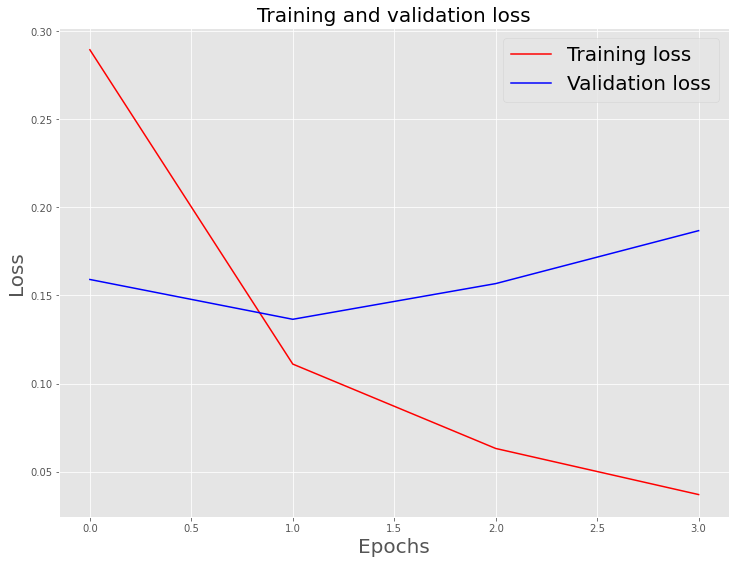

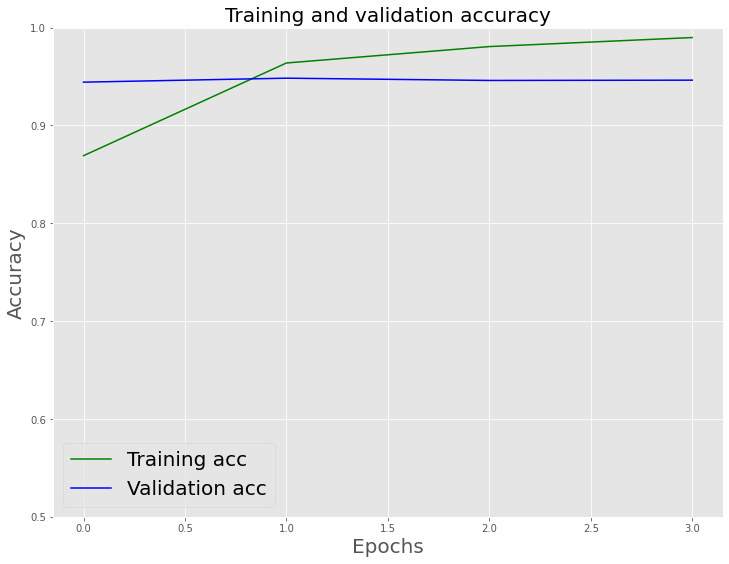

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

In [ ]:
X_test = X_test.apply(normalize_text)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Evaluation of the testing set:

In [ ]:
model.evaluate(X_test, y_test)

269/269 [==============================] - 4s 14ms/step - loss: 0.1398 - accuracy: 0.9477


[0.13978107273578644, 0.9476866126060486]

In [ ]:
y_pred = model.predict(X_test)
roc05 = (y_pred > 0.5) * 1

269/269 [==============================] - 5s 14ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

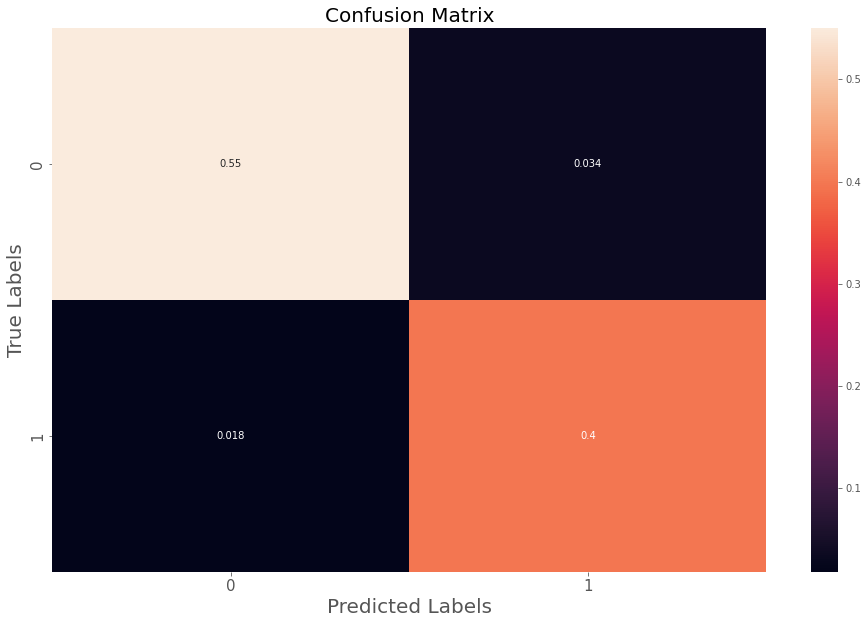

In [ ]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### ROC Curve

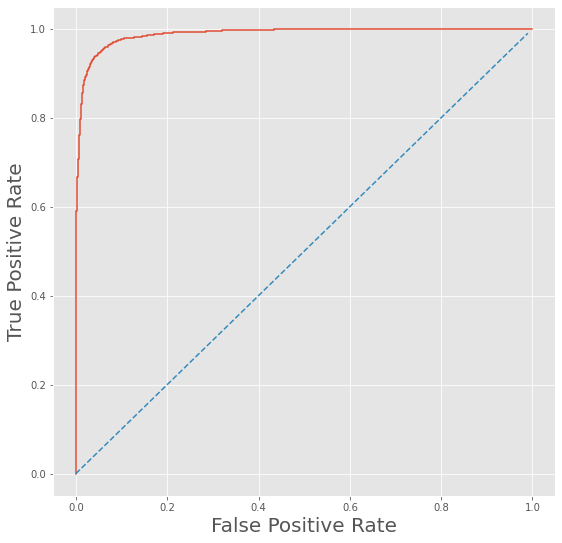

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.figure(figsize=(9,9))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

# Comments from validation team

1. Gdy chodzi o ewentualne uwagi to jesteście trochę niekonsekwentni przy usuwaniu linków, bo pozbywacie się "http://" ale nie ".com". Jest całkiem sporo linków w tych tekstach, które nie mają na początku ani http(s) ani www, ale za to mają .com na końcu. Ale lepiej chyba tego nie usuwać, bo jednak jest w tych danych pewna zależność między obecnością linku i tym, czy to fake news. Ewentualnie zamiast wyrzucać można to spróbować przekształcić

# NER Computations

### Run NER on entire train dataset - Takes about an HOUR

In [ ]:
# Load the pre-trained model
nlp = spacy.load("en_core_web_sm")

# Perform named entity recognition on the dataset
df["named_entities"] = df["text"].apply(lambda x: [ent.text for ent in nlp(x).ents])

# Create a vocabulary of named entities
all_named_entities = [ent for sublist in df["named_entities"].tolist() for ent in sublist]
named_entities_vocab = set(all_named_entities)

In [39]:
len(named_entities_vocab)

260720

### Save training data in order not to repeat computations

In [12]:
df.to_csv("train-with-ner.csv", encoding="utf-8")

In [13]:
!sha256sum ./train-with-ner.csv

eb92a2df787b180001b50018fa5818d3b9e3026f9cd3ccba711c5644c304f014  ./train-with-ner.csv


### SHA256SUM hash

930aab564e3cdde30046090859f089f1fd3f301c9b1d21d14eb41ae783063b70  ./train-with-ner.csv

# Second Try - Experiment with NER and LogisticRegression

Fail in terms of accuracy. Leason learned

## Download sample with NER included

Sample:
  - Train with NER: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip

In [8]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip && unzip -d data train-with-ner.zip

--2023-03-26 18:03:22--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-with-ner.zip [following]
--2023-03-26 18:03:22--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-with-ner.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58555589 (56M) [application/zip]
Saving to: ‘train-with-ner.zip’

train-with-ner.zip  100%[===================>]  55.84M   282MB/s    in 0.2s    

2023-03-26 18:03:24 (28

### Load downloaded sample

In [15]:
df = pd.read_csv("data/train-with-ner.csv", index_col=False)
# Remove Unnamed columns as they are a residue from previous indicies
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,text,real,named_entities
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0,"['Mosul', 'The Iraqi Army', 'Mosul', 'first', ..."
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0,"['Two', 'Republicans', 'John Boehner', 'Politi..."
2,MH370 search: Debris found in Reunion may give...,1,"['MH370', 'Debris', 'Reunion', 'Saint-Denis', ..."
3,A leading US senator: US Supporting War in Sy...,0,"['US', 'US Supporting War', 'Syria', 'US', 'Sy..."
4,Energy Update – Collective Gridwork Fluctuatio...,0,['Energy Update – Collective Gridwork Fluctuat...


## Preprocessing

In [89]:
all_named_entities = [ent for sublist in df['named_entities'].tolist() for ent in sublist]
named_entities_vocab = set(all_named_entities)

In [90]:
# Create a binary feature matrix for named entities
named_entities_matrix = np.zeros((len(df), len(named_entities_vocab)))
for i, named_entities in enumerate(df['named_entities']):
    for j, named_entity in enumerate(named_entities_vocab):
        if named_entity in named_entities:
            named_entities_matrix[i, j] = 1

In [91]:
def normalize_text(text: str) -> str:
    text = text.lower()
    # Get rid of urls
    text = re.sub("https?://\S+|www\.\S+", "", text)
    # Get rid of non words and extra spaces
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"[\s\n]+", " ", text)
    return text.strip()

df["normalized_text"] = df["text"].apply(normalize_text)

In [92]:
X_train, X_test, NER_train, NER_test, y_train, y_test = train_test_split(
    df["normalized_text"],  named_entities_matrix, df["real"],
    test_size=0.2, random_state=42
    )

## Words tokenization

In [93]:
MAX_VOCAB = 20000
MAX_LEN = 1000

tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN, padding='post')

In [94]:
X_train = np.concatenate([X_train, NER_train], axis=1)

In [95]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [96]:
# define model
clf = LogisticRegression(max_iter=1000)

# train model
clf.fit(X_scaled, y_train)

LogisticRegression(max_iter=1000)

In [97]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')
X_test = np.concatenate([X_test, NER_test], axis=1)

## Model creation and predictions

In [98]:
y_pred = clf.predict(X_test)

# evaluate model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.97      0.72      4888
           1       0.49      0.04      0.07      3714

    accuracy                           0.57      8602
   macro avg       0.53      0.50      0.39      8602
weighted avg       0.54      0.57      0.44      8602



# Third Try - Incorporating NER to LSTM and lematization

Another fail in terms of model fitting accuracy

## Download sample with NER included

Sample:
  - Train with NER: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip

In [5]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip && unzip -d data train-with-ner.zip

--2023-03-26 18:58:31--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-with-ner.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-with-ner.zip [following]
--2023-03-26 18:58:31--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-with-ner.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58555589 (56M) [application/zip]
Saving to: ‘train-with-ner.zip’

train-with-ner.zip  100%[===================>]  55.84M   321MB/s    in 0.2s    

2023-03-26 18:58:35 (32

### Load downloaded sample

In [6]:
df = pd.read_csv("data/train-with-ner.csv", index_col=False)
# Remove Unnamed columns as they are a residue from previous indicies
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,text,real,named_entities
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0,"['Mosul', 'The Iraqi Army', 'Mosul', 'first', ..."
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0,"['Two', 'Republicans', 'John Boehner', 'Politi..."
2,MH370 search: Debris found in Reunion may give...,1,"['MH370', 'Debris', 'Reunion', 'Saint-Denis', ..."
3,A leading US senator: US Supporting War in Sy...,0,"['US', 'US Supporting War', 'Syria', 'US', 'Sy..."
4,Energy Update – Collective Gridwork Fluctuatio...,0,['Energy Update – Collective Gridwork Fluctuat...


## Train/test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [17]:
type(X_train)

pandas.core.frame.DataFrame

In [18]:
punc_regex = re.compile('[%s]' % re.escape(string.punctuation))
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text: str) -> Iterable[str]:
    text = text.lower()
    # Get rid of urls
    text = re.sub("https?://\S+|www\.\S+", "", text)
    # Get rid of non words and extra spaces
    text = re.sub(r"\W", " ", text)
    # Remove punctuation
    text = re.sub(punc_regex, "", text)
    # Contract addtional spaces
    text = re.sub(r"[\s\n]+", " ", text)
    splited = text.strip().split()
    # Remove stop words
    splited = [w for w in splited if not w in stop_words]
    # Lemmatization
    splited = [lemmatizer.lemmatize(w) for w in splited]

    return splited

X_train["text"] = X_train["text"].apply(normalize_text)

In [23]:
MAX_VOCAB = 20000
MAX_LENGTH = 256

In [24]:
tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train["text"])

X_train["text"] = tokenizer.texts_to_sequences(X_train["text"])
X_train["text"] = tf.keras.preprocessing.sequence.pad_sequences(X_train["text"], padding='post', maxlen=256)

In [19]:
all_named_entities = [ent for sublist in X_train["named_entities"].tolist() for ent in sublist]
named_entities_vocab = set(all_named_entities)

In [25]:
# Create a binary feature matrix for named entities
named_entities_matrix = np.zeros((len(X_train), len(named_entities_vocab)))
for i, named_entities in enumerate(X_train['named_entities']):
    for j, named_entity in enumerate(named_entities_vocab):
        if named_entity in named_entities:
            named_entities_matrix[i, j] = 1

In [32]:
NER_INPUT_SIZE = named_entities_matrix.shape[1]

In [29]:
X_text_train = X_train["text"]
X_ner_train = named_entities_matrix

In [51]:
X_text_train

17452       91
1383       744
23277     1295
10538      732
36419     1566
         ...  
6265      4559
11284      600
38158    13541
860        208
15795     3925
Name: text, Length: 34407, dtype: int32

In [ ]:
text_input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
ner_input = tf.keras.layers.Input(shape=(NER_INPUT_SIZE,))

text_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_VOCAB, 256),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
])

merged = tf.keras.layers.concatenate([text_model.output, ner_input])
merged = tf.keras.layers.Dense(64, activation='relu')(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_model.input, ner_input], outputs=output)

model.summary()

In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit([X_text_train, X_ner_train], y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1033/1033 [==============================] - 22s 14ms/step - loss: 0.6201 - accuracy: 0.6062 - val_loss: 0.5149 - val_accuracy: 0.6882
Epoch 2/10
1033/1033 [==============================] - 15s 14ms/step - loss: 0.4641 - accuracy: 0.7554 - val_loss: 0.4748 - val_accuracy: 0.7527
Epoch 3/10
1033/1033 [==============================] - 14s 14ms/step - loss: 0.4015 - accuracy: 0.8053 - val_loss: 0.4582 - val_accuracy: 0.7774
Epoch 4/10
1033/1033 [==============================] - 14s 13ms/step - loss: 0.3629 - accuracy: 0.8303 - val_loss: 0.4573 - val_accuracy: 0.7855
Epoch 5/10
1033/1033 [==============================] - 14s 13ms/step - loss: 0.3443 - accuracy: 0.8404 - val_loss: 0.4549 - val_accuracy: 0.7940
Epoch 6/10
1033/1033 [==============================] - 11s 10ms/step - loss: 0.3300 - accuracy: 0.8491 - val_loss: 0.4595 - val_accuracy: 0.7963
Epoch 7/10
1033/1033 [==============================] - 13s 13ms/step - loss: 0.3214 - accuracy: 0.8515 - val_loss: 0.4706 -

# Forth Try - LSTM with lemmatization and additional metrics

Forget NER - focus on text

## (Optional) Load from preprocessed dataframe (2. checkpoint)

In [5]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip && unzip -d data train-checkpoint2.zip

--2023-03-26 20:59:23--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip [following]
--2023-03-26 20:59:23--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50750922 (48M) [application/zip]
Saving to: ‘train-checkpoint2.zip’

train-checkpoint2.z 100%[===================>]  48.40M   162MB/s    in 0.3s    

2023-03-26 20:5

In [6]:
df = pd.read_csv("data/train-checkpoint2.csv", index_col=False)

In [7]:
df.head()

,text,real
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0
2,MH370 search: Debris found in Reunion may give...,1
3,A leading US senator: US Supporting War in Sy...,0
4,Energy Update – Collective Gridwork Fluctuatio...,0


## Train/test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [9]:
type(X_train)

pandas.core.series.Series

## Text processing

In [10]:
punc_regex = re.compile('[%s]' % re.escape(string.punctuation))
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text: str) -> Iterable[str]:
    text = text.lower()
    # Get rid of urls
    text = re.sub("https?://\S+|www\.\S+", "", text)
    # Get rid of non words and extra spaces
    text = re.sub(r"\W", " ", text)
    # Remove punctuation
    text = re.sub(punc_regex, "", text)
    # Contract addtional spaces
    text = re.sub(r"[\s\n]+", " ", text)
    splited = text.strip().split()
    # Remove stop words
    splited = [w for w in splited if not w in stop_words]
    # Lemmatization
    splited = [lemmatizer.lemmatize(w) for w in splited]

    return splited

X_train = X_train.apply(normalize_text)

Converting text to vectors:

In [11]:
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

Application of padding (so we have the same length for each article):

In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)

## Model building

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_VOCAB, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

## Model fitting

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=20, shuffle=True, callbacks=[early_stop])

Epoch 1/10
 964/1549 [=================>............] - ETA: 5:30 - loss: 0.3517 - accuracy: 0.8335

## Training Visualization

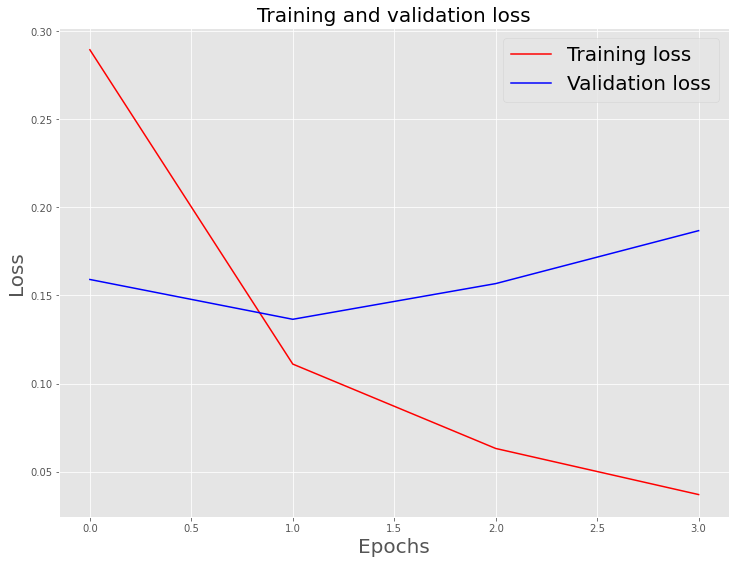

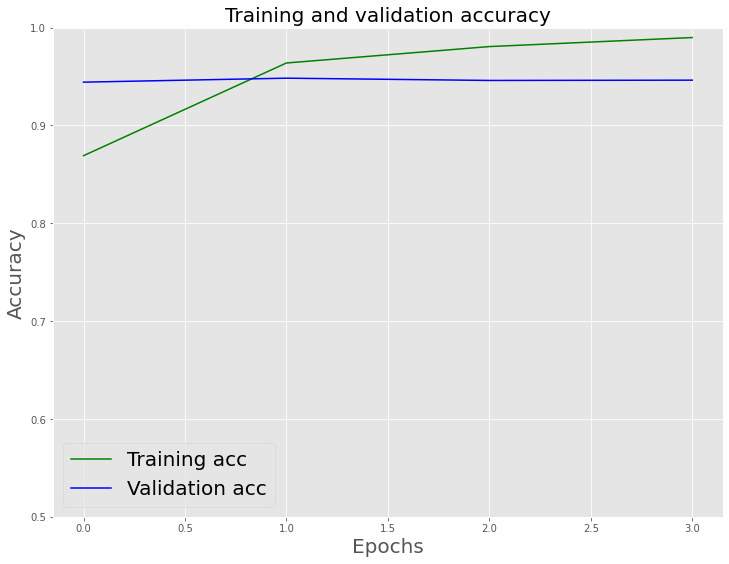

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

In [ ]:
X_test = X_test.apply(normalize_text)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Evaluation of the testing set:

In [ ]:
model.evaluate(X_test, y_test)

269/269 [==============================] - 4s 14ms/step - loss: 0.1398 - accuracy: 0.9477


[0.13978107273578644, 0.9476866126060486]

In [ ]:
y_pred = model.predict(X_test)
roc05 = (y_pred > 0.5) * 1

269/269 [==============================] - 5s 14ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

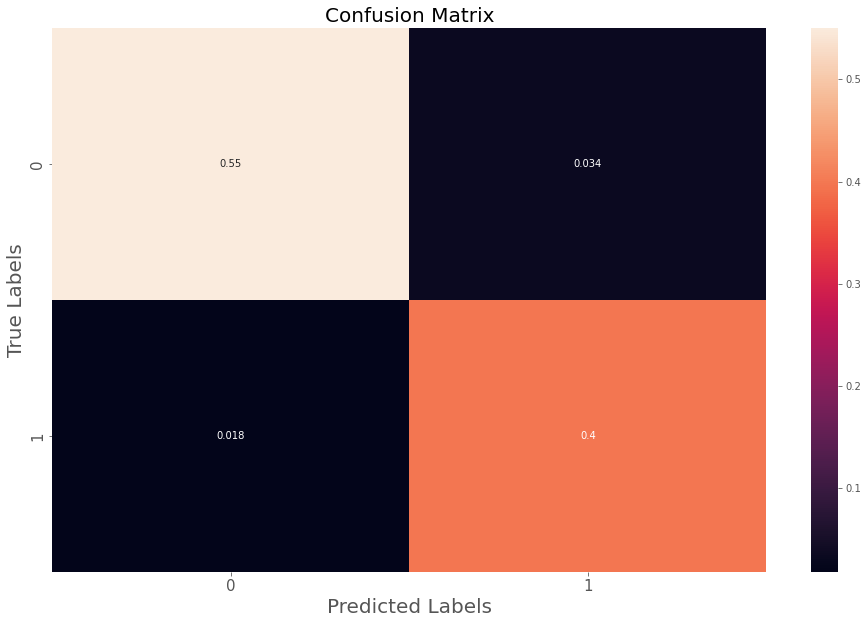

In [ ]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### ROC Curve

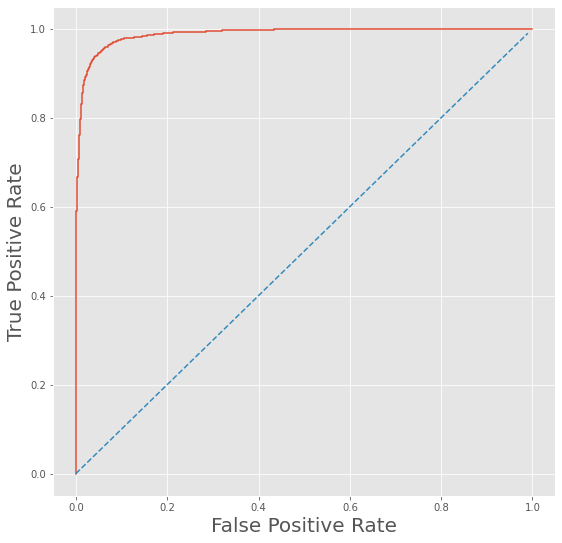

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.figure(figsize=(9,9))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()